In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download FER2013 dataset
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d fer2013_data

Streaming output truncated to the last 5000 lines.
  inflating: fer2013_data/train/sad/Training_65242339.jpg  
  inflating: fer2013_data/train/sad/Training_65267116.jpg  
  inflating: fer2013_data/train/sad/Training_65275626.jpg  
  inflating: fer2013_data/train/sad/Training_6529266.jpg  
  inflating: fer2013_data/train/sad/Training_65329617.jpg  
  inflating: fer2013_data/train/sad/Training_65338712.jpg  
  inflating: fer2013_data/train/sad/Training_65338797.jpg  
  inflating: fer2013_data/train/sad/Training_65387162.jpg  
  inflating: fer2013_data/train/sad/Training_65404494.jpg  
  inflating: fer2013_data/train/sad/Training_65426218.jpg  
  inflating: fer2013_data/train/sad/Training_65430136.jpg  
  inflating: fer2013_data/train/sad/Training_65437377.jpg  
  inflating: fer2013_data/train/sad/Training_6545735.jpg  
  inflating: fer2013_data/train/sad/Training_65463385.jpg  
  inflating: fer2013_data/train/sad/Training_65473985.jpg  
  inflating: fer2013_data/train/sad/Training_655028

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [3]:
train_dir = '/content/fer2013_data/train/'
test_dir = '/content/fer2013_data/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       neutral  disgust  fear  happy  angry  surprise   sad
train     4965      436  4097   7215   3995      3171  4830
      neutral  disgust  fear  happy  angry  surprise   sad
test     1233      111  1024   1774    958       831  1247


<Axes: >

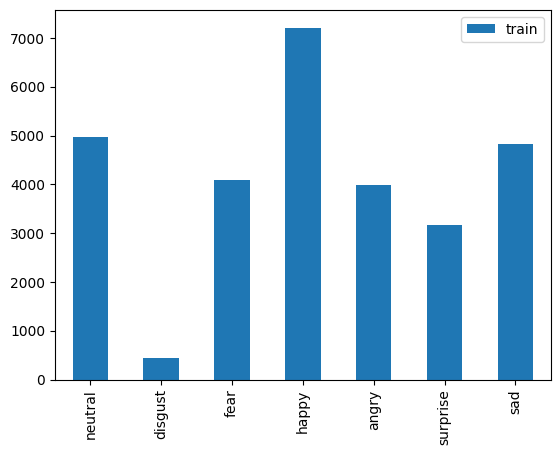

In [4]:
train_count.transpose().plot(kind='bar')

<Axes: >

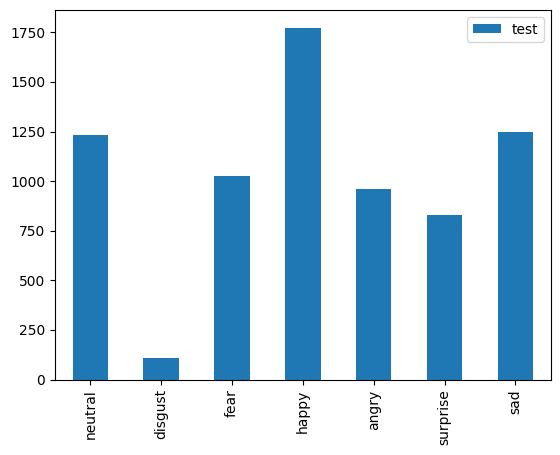

In [5]:
test_count.transpose().plot(kind='bar')

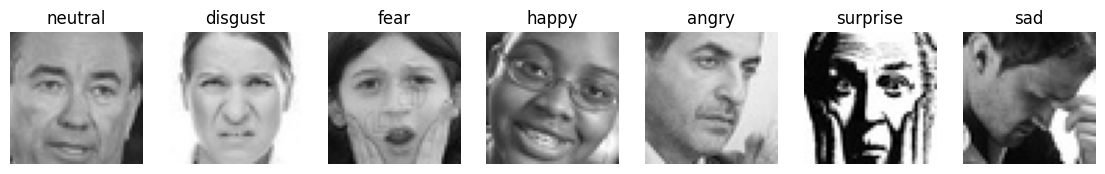

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [9]:
def get_model(input_size, classes=7):
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [10]:
fernet = get_model((row,col,1), classes)
fernet.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      31,720,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,116,743 (122.52 MB)

 Trainable params: 32,116,103 (122.51 MB)

 Non-trainable params: 640 (2.50 KB)

In [11]:
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    CSVLogger
)

chk_path = 'ferNet.keras'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger, tensorboard_callback]


In [ ]:
steps_per_epoch = training_set.n
validation_steps = test_set.n

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 12/448 ━━━━━━━━━━━━━━━━━━━━ 29:23 4s/step - accuracy: 0.1669 - loss: 8.3369

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
fernet.save_weights('fernet_bestweight.h5')

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)